In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt                         # plotting
import seaborn as sn  
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
from sklearn import neighbors               # includes kNN!
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from random import randrange
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier

# names=['Th','Ph','E','NrHits','NrBumps','E1','E1E9','E9E25','Z20','Z53','LatMom'], delimiter=','
emc_gam  = pd.read_csv("https://transfer.sh/DXTWSG/emc_gam.csv")
emc_neutron = pd.read_csv("https://transfer.sh/QLpEb4/emc_neutron.csv")

# This is needed for training the model. It has to know if it's right.
emc_gam["type"] = 1
emc_neutron["type"] = 0

# Shove them into one big dataset for faster plotting.
dataset = pd.concat([emc_gam, emc_neutron],ignore_index=True)


print(dataset)

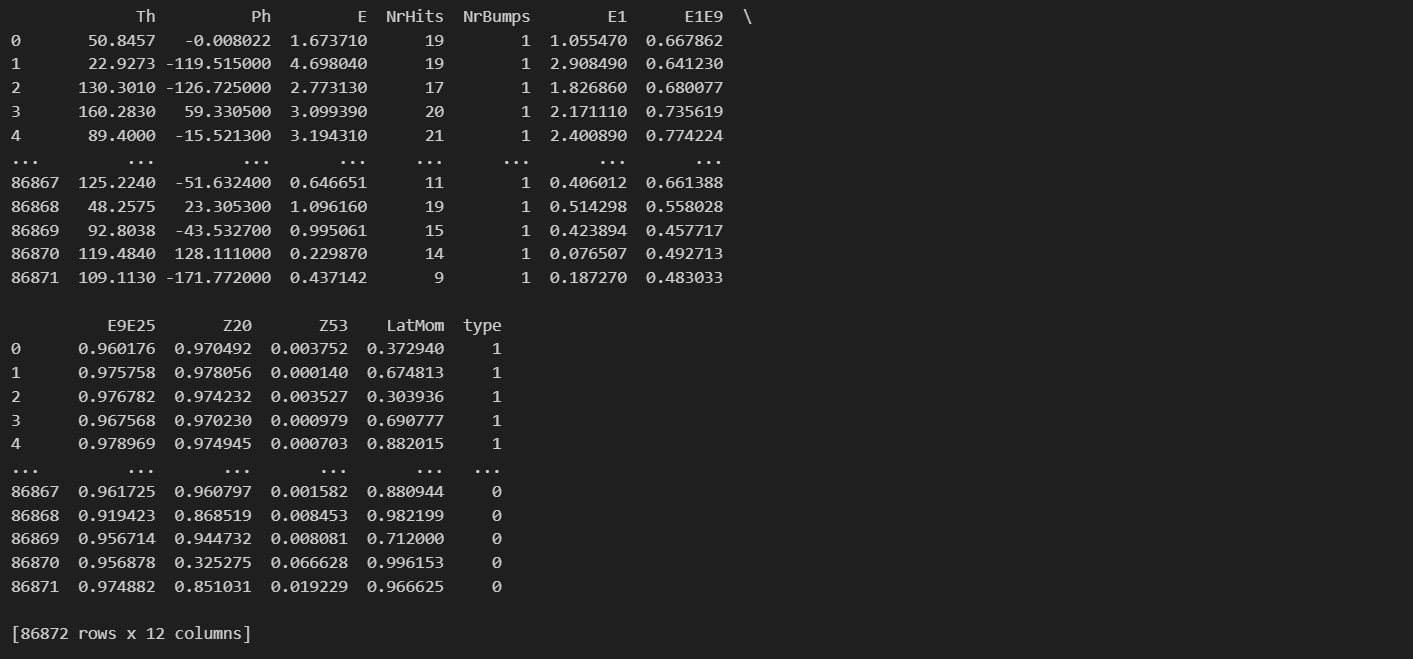

In [ ]:
# #rrggbb in hex
colors = ["#ff0000", "#0000ff"]

# if i>len(emc_gam) we are plotting the emc_neutron and this expression evalues to False, which is just 0. 
# It will have colors[0] if True then colors[1]
something = pd.plotting.scatter_matrix(dataset, figsize=(25,25), diagonal='hist', alpha=0.03, color = [colors[i>len(emc_gam)] for i in range(len(dataset))])


plt.show()

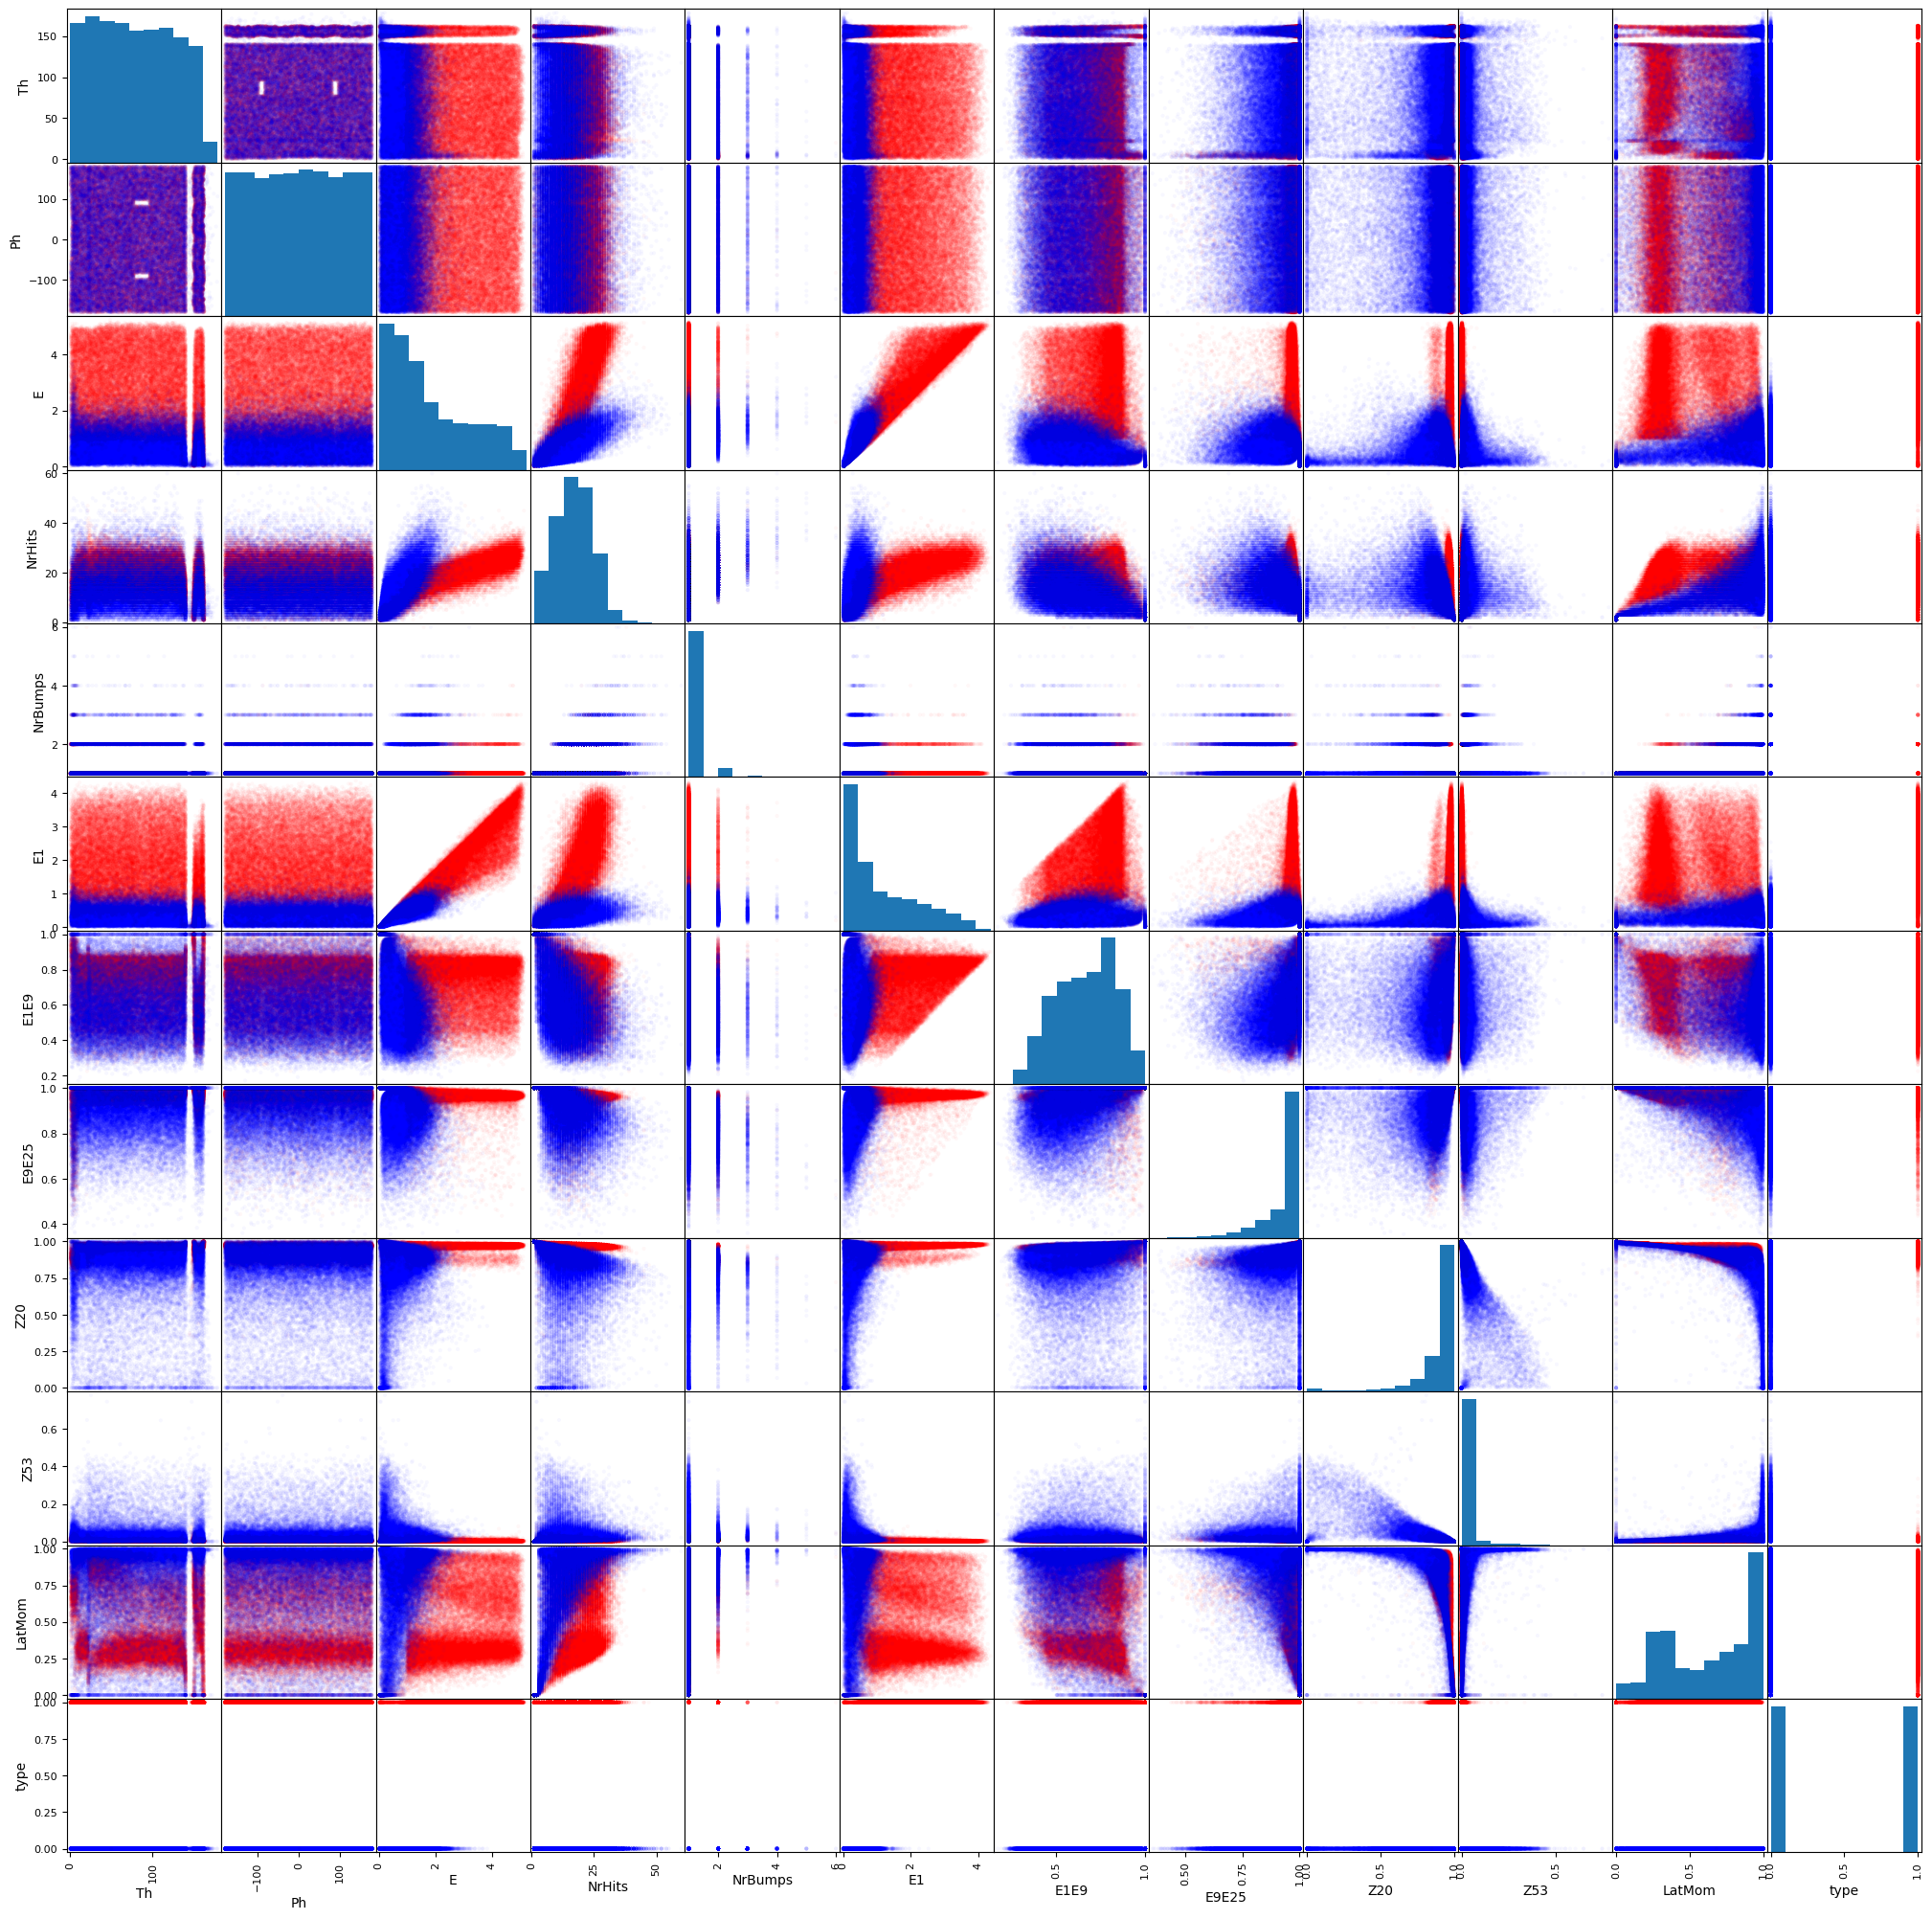

From our observations we can conclude that the paramters which were more relevant were E, E1, E1E9, E9E25, Z20, LatMom, NrHits, as they were the ones with less correlation. We therefore decided to study the correlation between this paramters and see how they relate with each other. 

In [ ]:
correlation_matrix = dataset[['E','NrHits','E1','E1E9','E9E25', 'Z20','LatMom' ]].corr()
plt.figure(figsize=(10, 10))
sn.heatmap(correlation_matrix, annot=True)
plt.show()

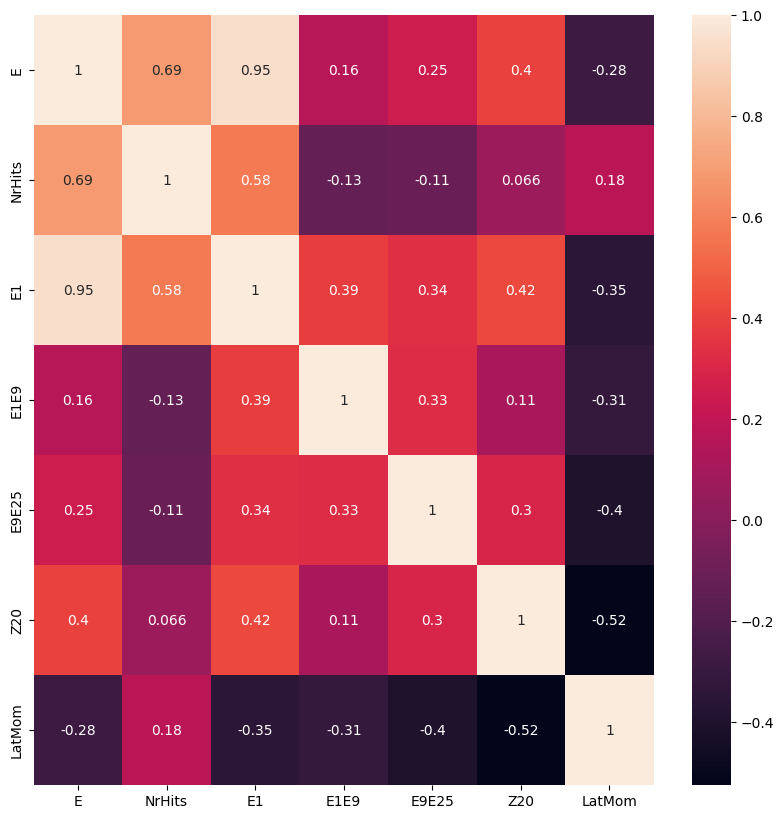

 The matric abouve shows the correlation relation betweewn paramters. 
 If 2 paramters have a high correlation( ie. 1), then the data for both will be the same, hence the infmation provided by both will be irrelevant as just the data set from 1 parameter will be enough as it will reduce the possibiloty of maximizing FOM. 
 From the correlation matrix, we can convlude that there is a strong relation (0.95) between E and E1 fro both enutron and gamma rays. We can also see that E against NrHits have a high correlation (0.69).

In [ ]:
emc_gam[['Th','Ph','E','NrHits','NrBumps','E1','E1E9','E9E25','Z20','Z53','LatMom']].describe()

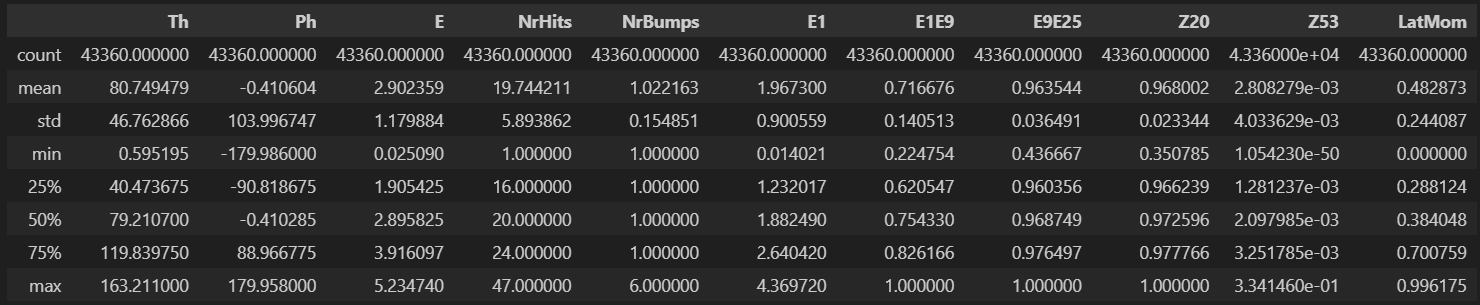

In [ ]:
emc_neutron[['Th','Ph','E','NrHits','NrBumps','E1','E1E9','E9E25','Z20','Z53','LatMom']].describe()

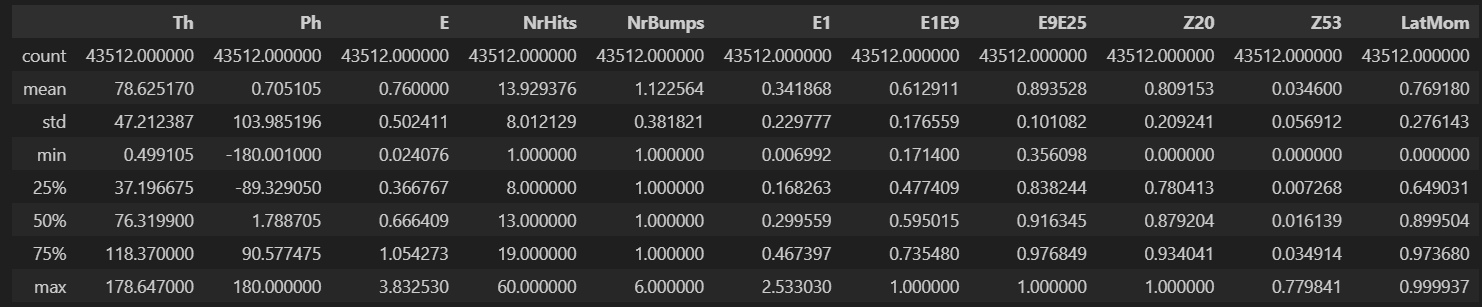

In [ ]:
#scaler = StandardScaler()

#scaled_data = scaler.fit_transform(dataset)
#print(np.mean(scaled_data,axis=0),np.std(scaled_data,axis=0))

dataset['E'] = ( dataset.E - dataset.E.mean() ) / dataset.E.std()
dataset['E1']        = ( dataset.E1        - dataset.E1.mean() )        / dataset.E1.std()
dataset['NrHits']     = ( dataset.NrHits     - dataset.NrHits.mean() )     / dataset.NrHits.std()
dataset['E1E9']       = ( dataset.E1E9       - dataset.E1E9.mean() )       / dataset.E1E9.std()

dataset['Th']       = ( dataset.Th       - dataset.Th.mean() )       / dataset.Th.std()
dataset['Ph']       = ( dataset.Ph       - dataset.Ph.mean() )       / dataset.Ph.std()
dataset['NrBumps']       = ( dataset.NrBumps       - dataset.NrBumps.mean() )       / dataset.NrBumps.std()
dataset['E9E25']       = ( dataset.E9E25       - dataset.E9E25.mean() )       / dataset.E9E25.std()
dataset['Z20']       = ( dataset.Z20       - dataset.Z20.mean() )       / dataset.Z20.std()
dataset['Z53']       = ( dataset.Z53       - dataset.Z53.mean() )       / dataset.Z53.std()
dataset['LatMom']       = ( dataset.LatMom       - dataset.LatMom.mean() )       / dataset.LatMom.std()

In [ ]:
dataset.describe()

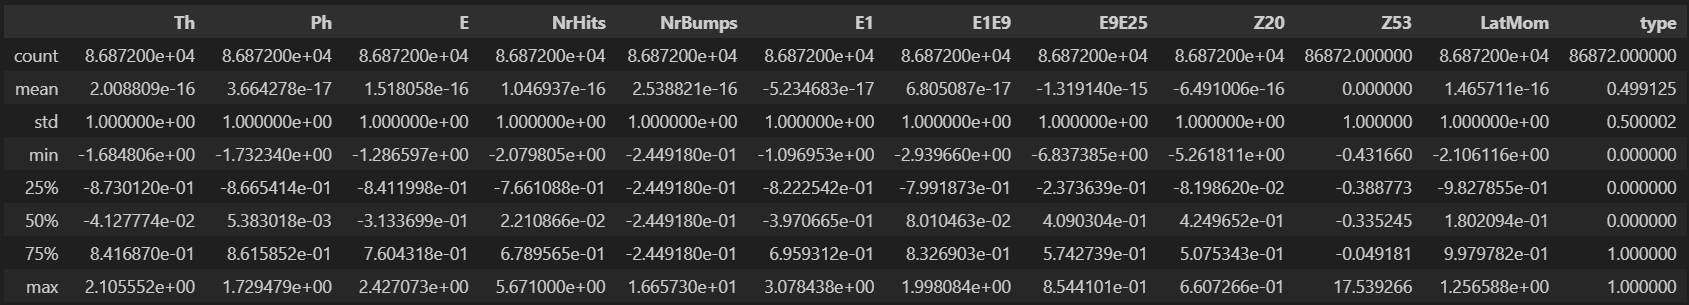

In [ ]:
# #sel_1 = np.array([list(scaled_data[0:,3]), list(scaled_data[0:,5])]).T
# sel_1 = dataset[['E1', 'NrHits']].values # create numpy array from a DataFrame


# start = np.array([[0, 1]])

# k = 2 #number of clusters
# #kmeans = cluster.KMeans(n_clusters=k, max_iter=100, init='k-means++', n_init=1)
# kmeans = cluster.KMeans(n_clusters=k, max_iter=1000, init=start, n_init=1)
# kmeans.fit(sel_1)

# #
# # The output of the "fit" are arrays of list of labels matching input data set,
# # the found centroids, and other useful parameters such as number of iterations it took.
# #
# labels    = kmeans.labels_
# centroids = kmeans.cluster_centers_
# nriter    = kmeans.n_iter_

# #
# # Print the output parameters of the cluster "fit"
# #
# print("labels:    ", labels)
# print("centroids: ", centroids)
# print("nriters:   ", nriter)

In [ ]:
# Plot function of labeled data and centroids
# I defined a function, since I want to use it later for another cluster algorithm
# #
# def plot_clusters(data, centroids, labels):
#     plt.figure(figsize=(10, 8))
#     for i in range(len(centroids)):
#         subset = data[np.where(labels==i)]
#         plt.scatter(subset[:,0],subset[:,1],s=0.5)
#         lines = plt.plot(centroids[i,0],centroids[i,1],'kx')
#         plt.setp(lines,ms=15.0, mew=3.0)
#     plt.xlabel('E1')
#     plt.ylabel('NrHits')  
#     plt.show()

# plot_clusters(sel_1, centroids, labels)

## 2nd Part

In [1]:
def FOM(p, r):
    """"This fucntion will return the value of the figure of merit (FOM)
    p = model prediction
    r = what it actually is (reality)
    """
    signal = np.sum((p + r) ==2 ) # If both P and R are 1 then it's added up. AKA if it's predicted correctly.
    background = np.sum(p) - signal # 

    return signal /(signal + background)**1/2



def fit(dataset, parameter, test_size, classifier):

    X_train, X_test, Y_train, Y_test = train_test_split(dataset[parameter], dataset[['type']],test_size=test_size)

    classifier.fit(np.array(X_train), np.array(Y_train))

    Y_pred_train = classifier.predict(np.array(X_train))
    X_train['p']= Y_pred_train
    result_tr = X_train

    Y_pred_test = classifier.predict(np.array(X_test))
    X_test['p']= Y_pred_test
    result_te = X_test
    #print(accuracy_score(Y_test, Y_pred_test))

    return np.array(result_te), np.array(result_tr), FOM(np.array(Y_pred_test), np.array(Y_test)), FOM(np.array(Y_pred_train), np.array(Y_train))

def ML(dataset,feats, vals, classifier, **kwargs):

    result_te = np.empty((len(vals),len(dataset)//2,len(feats)+1))
    result_tr = np.empty((len(vals),len(dataset)//2,len(feats)+1))
    fom_te = np.empty(len(vals))
    fom_tr = np.empty(len(vals))

    classifiers = [classifier(i,**kwargs) for i in vals]


    for i,k in enumerate(classifiers):
        result_te[i], result_tr[i], fom_te[i], fom_tr[i] = fit(dataset,feats,0.5,k)


    max=np.argmax(fom_te)
    print("test: ",vals[max], fom_te[max])

    max=np.argmax(fom_tr)
    print("train: ",vals[max], fom_tr[max])
    
    return fom_te, fom_tr

In [ ]:
feats=['E','NrHits','E1E9','E9E25','Z20','LatMom']

#kN Optimizing
k_vals = np.arange(1,10,1)
kNfoms=ML(dataset,feats,k_vals,KNeighborsClassifier)

#Plotting kN
plt.figure(figsize = (10,10))
plt.plot(k_vals, kNfoms[0], label = "test")
plt.plot(k_vals, kNfoms[1], label = "train")
plt.xlabel("n_neighbours" )
plt.ylabel("FOM")
plt.legend()
fig=plt.gcf()
plt.show()
fig.savefig(f"kNfoms")

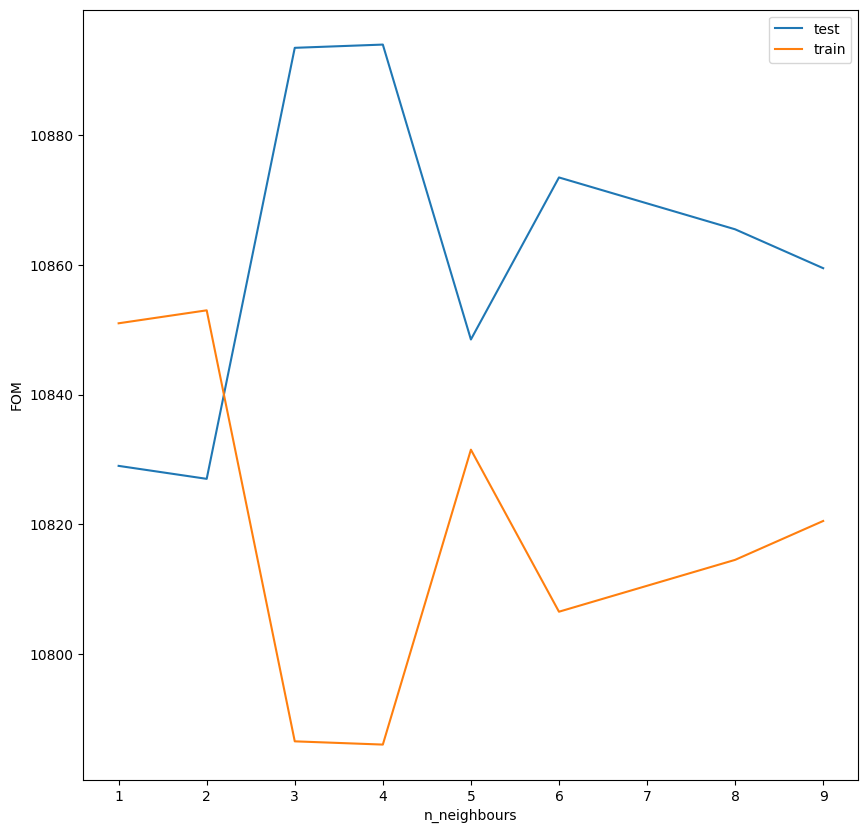

In [ ]:
feats=['E','NrHits','E1E9','E9E25','Z20','LatMom']

#RF Optimizing
trees = np.arange(8,19,2)
criter="gini"
RFfoms=ML(dataset,feats,trees,RandomForestClassifier,criterion=criter)

#Plotting RF

plt.figure(figsize = (10,10))
plt.plot(trees, RFfoms[0], label = "test")
plt.plot(trees, RFfoms[1], label = "train")
plt.xlabel("n_trees" )
plt.ylabel("FOM")
plt.legend()
fig=plt.gcf()
plt.show()
fig.savefig(f"RF({criter})")

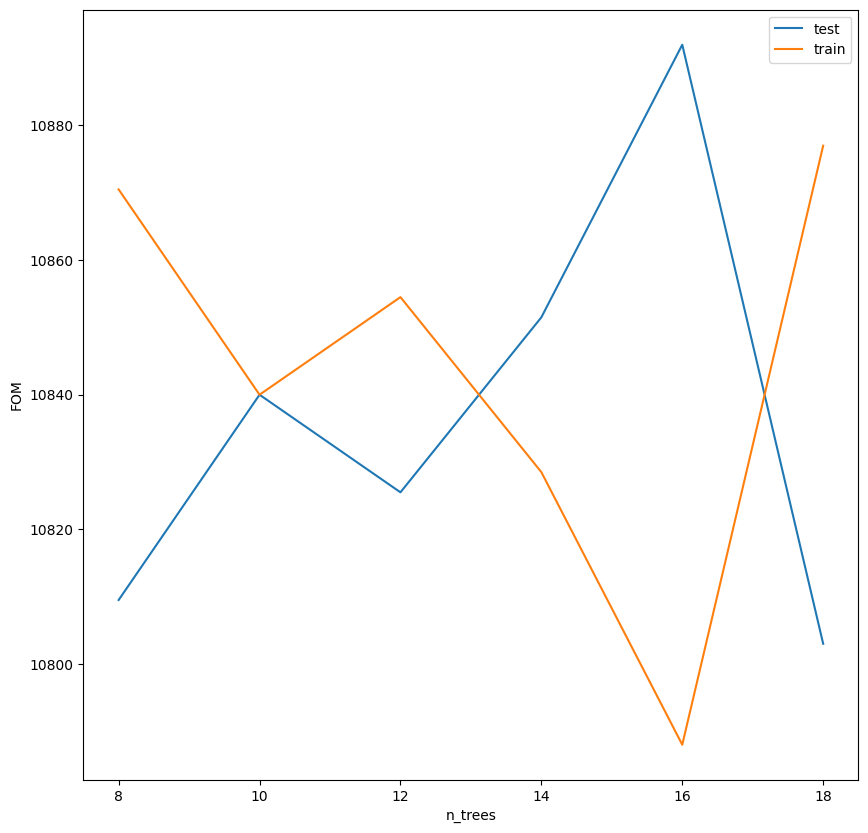

In [ ]:
#Plotting RF

plt.figure(figsize = (10,10))
plt.plot(trees, RFfoms[0], label = "test")
plt.plot(trees, RFfoms[1], label = "train")
plt.xlabel("n_trees" )
plt.ylabel("FOM")
plt.legend()
plt.show()


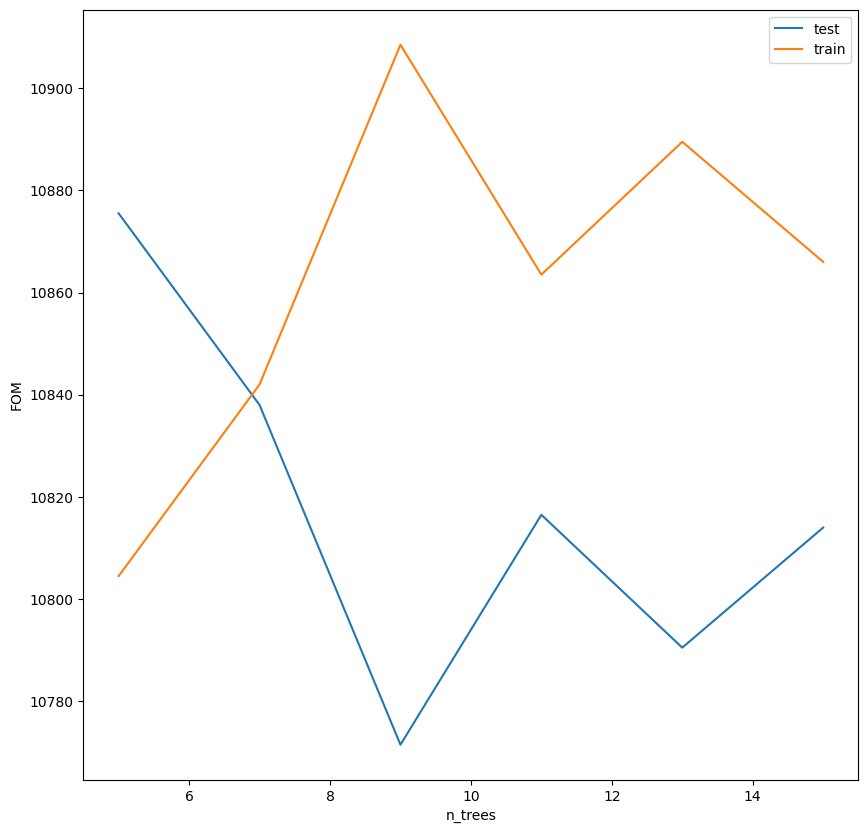

In [ ]:
hidden_layers = 1

clf = MLPClassifier(solver='lbfgs', activation='logistic', 
                            max_iter=5000, 
                            hidden_layer_sizes=hidden_layers)